# Improved SCA based on SVM
---

In this notebook, we will utilize the trained models to predict the intermediate value and deduce the specific byte of the encryption key.

`Note:` This is the Bit model attack, make sure you've trained the bit models or use the included models.

---

#### 1. Importing attack traces and models

In [3]:
import chipwhisperer as cw
import numpy as np

In [2]:
byte_index = 0
print(f'We are attacking byte {byte_index}')

We are attacking byte 0


In [60]:
import joblib

# To use the included Traces
# project_file = 'SCA_SVM_DATA/Included/traces/attack_traces.cwp'

project_folder = 'SCA_SVM_DATA'    
traces_folder = f'{project_folder}/traces'
project_file = f'{traces_folder}/attack_traces.cwp'

project = cw.open_project(project_file)
traces = np.array(project.waves)
textins = project.textins
unknown_key = project.keys[0][byte_index]
hex_unknown_key = hex(unknown_key)

print(f'✅ Loaded {len(traces)} traces and textins with the unknown key {hex_unknown_key}')

✅ Loaded 10000 traces and textins with the unknown key 0xf4


In order to load the model we need to have the pearson correlation

In [15]:
from scipy.stats import pearsonr

# Compute Pearson correlation for each trace point.
def pearson_corr(X, y):
    return np.array([ abs(pearsonr(X[:, i], y)[0]) for i in range(X.shape[1])])

In [98]:
# To use the included models

models_data = []
for bit in range(8):
    model_file = f'SCA_SVM_DATA/Included/models/bit{bit}_model.pkl'
    model_data = joblib.load(model_file)
    models_data.append(model_data)
print(f'✅ Loaded the attack models')

✅ Loaded the attack models


In [ ]:
# To use your own models

model_folder = f'{project_folder}/models'

models_data = []
for bit in range(8):
    model_file = f'{model_folder}/bit{bit}_model.pkl'
    
    model_data = joblib.load(model_file)
    models_data.append(model_data)

print(f'✅ Loaded the attack models')

#### 2. Attacking the S-Box
Since we perform a profiled attack, the S-box remains unchanged across devices.

We apply the same preprocessing as in the training phase to obtain a prediction, which represents the of the S-box output. 

Knowing the plaintext and the S-box contents, we iterate over all possible keys, checking which ones produce an intermediate value that is the same as the predicted one.

The key that appears most frequently is likely the correct one.

In [53]:
SBOX = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

In [54]:
def get_bit(value, bit_pos):
    return (value >> bit_pos) & 1

In [55]:
def bits_to_number(bits):
    number = 0
    for bit in bits:
        number = (number << 1) | bit  # Left-shift and OR
    return number

In [136]:
def get_k_counters(T):
    predictions = []
    for bit in range(8):
        model_data = models_data[bit]
        model = model_data['model']
        N = model_data['N']
        selector = model_data['selector']
        features = selector.transform(traces[:T])[:,:N]
        predictions.append(model.predict(features))
        
    predictions = np.array(predictions)
    predicted_numbers = predictions[::-1].T
    
    k_counters = np.zeros(256, dtype=int)
    for i in range(T):
        for K in range(256):
            P = textins[i][0]
            s = SBOX[K^P]
            c = bits_to_number(predicted_numbers[i])
            if s == c:
                k_counters[K]+=1

    return k_counters

In [144]:
def attack(T,get_k_counters):
    k_counters = get_k_counters(T)
    max_value = np.max(k_counters)
    max_indices = np.where(k_counters == max_value)[0]
    keys = [hex(i) for i in max_indices]
    print(f'#Traces={T}: {len(keys)} possible keys: {keys}')
    return keys

In [145]:
T = 20
for i in range(1,T):
    attack(i,get_k_counters)

#Traces=1: 1 possible keys: ['0xb8']
#Traces=2: 2 possible keys: ['0xb8', '0xdc']
#Traces=3: 3 possible keys: ['0xb8', '0xdc', '0xf4']
#Traces=4: 4 possible keys: ['0x2d', '0xb8', '0xdc', '0xf4']
#Traces=5: 5 possible keys: ['0x2d', '0xb8', '0xbc', '0xdc', '0xf4']
#Traces=6: 6 possible keys: ['0x2d', '0xb8', '0xbc', '0xd4', '0xdc', '0xf4']
#Traces=7: 7 possible keys: ['0x2d', '0x41', '0xb8', '0xbc', '0xd4', '0xdc', '0xf4']
#Traces=8: 8 possible keys: ['0x2d', '0x41', '0x90', '0xb8', '0xbc', '0xd4', '0xdc', '0xf4']
#Traces=9: 9 possible keys: ['0x2d', '0x41', '0x6c', '0x90', '0xb8', '0xbc', '0xd4', '0xdc', '0xf4']
#Traces=10: 10 possible keys: ['0x2d', '0x41', '0x65', '0x6c', '0x90', '0xb8', '0xbc', '0xd4', '0xdc', '0xf4']
#Traces=11: 11 possible keys: ['0x2d', '0x41', '0x65', '0x6c', '0x90', '0xb2', '0xb8', '0xbc', '0xd4', '0xdc', '0xf4']
#Traces=12: 12 possible keys: ['0x2d', '0x41', '0x65', '0x67', '0x6c', '0x90', '0xb2', '0xb8', '0xbc', '0xd4', '0xdc', '0xf4']
#Traces=13: 13 possibl

### 🎉 Success!
After just 15 traces, the correct key is the only remaining possibility!  

Now, let's visualize it:

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as animation
from IPython.display import Video


# Function to generate a key probability heatmap
def visualize_key_heatmap(ax, k_counters, T):
    ax.clear()
    
    # Reshape to 16x16 grid
    key_grid = k_counters.reshape((16, 16))
    
    # Create heatmap
    cmap = plt.cm.viridis
    norm = mcolors.Normalize(vmin=0, vmax=np.max(k_counters) + 1)
    
    im = ax.imshow(key_grid, cmap=cmap, norm=norm)

    # Add key labels
    for i in range(16):
        for j in range(16):
            key_hex = f"{i*16 + j:02X}"
            ax.text(j, i, key_hex, ha="center", va="center", fontsize=8, color="black")
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Key Candidates After {T} Traces")

    return im

# Function to create animation
def generate_mp4(file_name, T, fps, counters):
    fig, ax = plt.subplots(figsize=(6,6))

    def update(T):
        k_counters = counters(T)
        return visualize_key_heatmap(ax, k_counters, T)
    
    ani = animation.FuncAnimation(fig, update, frames=range(1, T+1), interval=2000, blit=False)
    
    # Save as MP4
    ani.save(file_name, writer="ffmpeg", fps=fps)
    
    return video_path

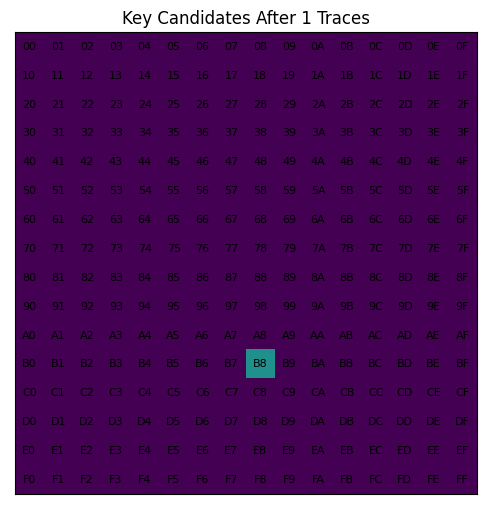

In [140]:
video_path = generate_mp4(f'{project_folder}/BIT_key_recovery.mp4', 30, 5, get_k_counters)
Video(video_path, embed=True)

#### 3. Improving the attack
15 traces is a remarkably low number to break the key, considering that it took 250 traces with DPA.
Still, let's aim to refine the attack and reduce the trace count even further.

---

We'll start by "cheating" and comparing a few **predicted** intermediate values to the **actual** intermediates (extracted from the provided models and traces):
```
Actual: 	  11010011
Predicted:	11011001

Actual: 	  10000101
Predicted:	10000100

Actual: 	  00011011
Predicted:	00011011

Actual: 	  01110110
Predicted:	11110110

Actual: 	  11111101
Predicted:	11111001

Actual: 	  01000000
Predicted:	00000000
```
The values are clearly very similar, with at most one or two bits flipped. This means both numbers have a nearly identical count of 1's.... essentially the same **Hamming weight!**

So, we can leverage our pretrained model to predict the Hamming weight and use it to refine the key guessing process, narrowing down the possibilities more efficiently.

In [119]:
# To use the included model
# model_file = 'SCA_SVM_DATA/models/hw_model.pkl'

model_file = f'{project_folder}/models/hw_model.pkl'

model_data = joblib.load(model_file)
model = model_data['model']
p = model_data['p']

print(f'✅ Loaded the attack model')

✅ Loaded the attack model


In [120]:
def hamming_weight(value):
    return bin(value).count('1')

In [142]:
def get_k_counters_HW(T):
    predictions = []
    for bit in range(8):
        model_data = models_data[bit]
        model = model_data['model']
        N = model_data['N']
        selector = model_data['selector']
        features = selector.transform(traces[:T])[:,:N]
        predictions.append(model.predict(features))
        
    predictions = np.array(predictions)
    predicted_numbers = predictions[::-1].T

    k_counters = np.zeros(256, dtype=int)
    for i in range(T):
        for K in range(256):
            P = textins[i][0]
            s = SBOX[K^P]
            c = bits_to_number(predicted_numbers[i])
            if s == c or abs(hamming_weight(s)-hamming_weight(c))<=1:
                k_counters[K]+=1

    return k_counters

In [146]:
for i in range(1,T):
    attack(i, get_k_counters_HW)

#Traces=1: 154 possible keys: ['0x2', '0x4', '0x5', '0x6', '0x7', '0x8', '0xa', '0xb', '0xc', '0xd', '0xe', '0x10', '0x13', '0x14', '0x16', '0x17', '0x18', '0x19', '0x1b', '0x22', '0x23', '0x24', '0x25', '0x27', '0x28', '0x2a', '0x2c', '0x2e', '0x30', '0x33', '0x34', '0x38', '0x3b', '0x3f', '0x41', '0x43', '0x44', '0x45', '0x46', '0x48', '0x49', '0x4a', '0x4b', '0x4d', '0x4e', '0x4f', '0x50', '0x52', '0x53', '0x56', '0x57', '0x58', '0x59', '0x5a', '0x5b', '0x5c', '0x5d', '0x5e', '0x5f', '0x60', '0x61', '0x62', '0x63', '0x66', '0x68', '0x6a', '0x6c', '0x6e', '0x70', '0x71', '0x74', '0x76', '0x77', '0x78', '0x79', '0x7a', '0x7d', '0x7f', '0x82', '0x83', '0x84', '0x86', '0x87', '0x8b', '0x8c', '0x8e', '0x8f', '0x90', '0x91', '0x93', '0x94', '0x95', '0x96', '0x97', '0x98', '0x9a', '0x9b', '0x9c', '0x9d', '0x9e', '0xa3', '0xa4', '0xa6', '0xa7', '0xa8', '0xb0', '0xb1', '0xb4', '0xb5', '0xb6', '0xb7', '0xb8', '0xb9', '0xbb', '0xbc', '0xbd', '0xc0', '0xc1', '0xc2', '0xc4', '0xc7', '0xce', '0xc

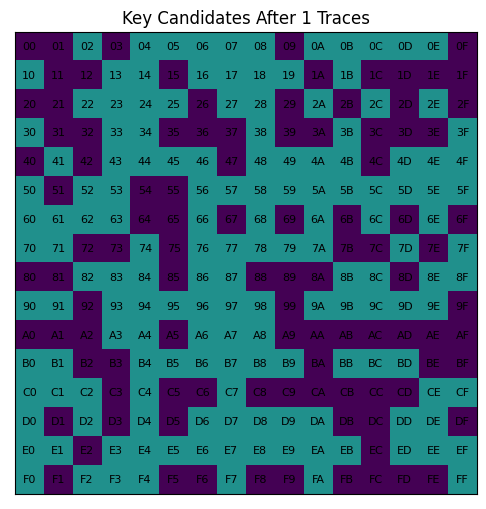

In [147]:
video_path = generate_mp4(f'{project_folder}/BIT_key_recovery_HW.mp4', 30, 10, get_k_counters_HW)
Video(video_path, embed=True)

### 🎉 Success!
We've reduced the number of traces from 15 to just 6 - nice! But can we push it even further?

Let's take a closer look at the intermediate values again:
```
Actual: 	  11010011
Predicted:	11011001

Actual: 	  10000101
Predicted:	10000100

Actual: 	  00011011
Predicted:	00011011

Actual: 	  01110110
Predicted:	11110110

Actual: 	  11111101
Predicted:	11111001

Actual: 	  01000000
Predicted:	00000000
```
If two bits are flipped, where 1 becomes 0 and 0 becomes 1, the Hamming weight remains the same, but the actual number is noticeably different.

To quantify this effect, we use Hamming Distance:

In [148]:
def hamming_distance(num1, num2):
    return bin(num1 ^ num2).count('1')

In [150]:
def get_k_counters_HD(T):
    predictions = []
    for bit in range(8):
        model_data = models_data[bit]
        model = model_data['model']
        N = model_data['N']
        selector = model_data['selector']
        features = selector.transform(traces[:T])[:,:N]
        predictions.append(model.predict(features))
        
    predictions = np.array(predictions)
    predicted_numbers = predictions[::-1].T

    k_counters = np.zeros(256, dtype=int)
    for i in range(T):
        for K in range(256):
            P = textins[i][0]
            s = SBOX[K^P]
            c = bits_to_number(predicted_numbers[i])
            if s == c or hamming_distance(s,c)<=1:
                k_counters[K]+=1

    return k_counters

In [151]:
for i in range(1,T):
    attack(i, get_k_counters_HD)

#Traces=1: 9 possible keys: ['0xc', '0x34', '0x48', '0x4f', '0x70', '0x94', '0xa4', '0xb8', '0xc2']
#Traces=2: 1 possible keys: ['0x4f']
#Traces=3: 2 possible keys: ['0x4f', '0xf4']
#Traces=4: 1 possible keys: ['0xf4']
#Traces=5: 1 possible keys: ['0xf4']
#Traces=6: 1 possible keys: ['0xf4']
#Traces=7: 1 possible keys: ['0xf4']
#Traces=8: 1 possible keys: ['0xf4']
#Traces=9: 1 possible keys: ['0xf4']
#Traces=10: 1 possible keys: ['0xf4']
#Traces=11: 1 possible keys: ['0xf4']
#Traces=12: 1 possible keys: ['0xf4']
#Traces=13: 1 possible keys: ['0xf4']
#Traces=14: 1 possible keys: ['0xf4']
#Traces=15: 1 possible keys: ['0xf4']
#Traces=16: 1 possible keys: ['0xf4']
#Traces=17: 1 possible keys: ['0xf4']
#Traces=18: 1 possible keys: ['0xf4']
#Traces=19: 1 possible keys: ['0xf4']


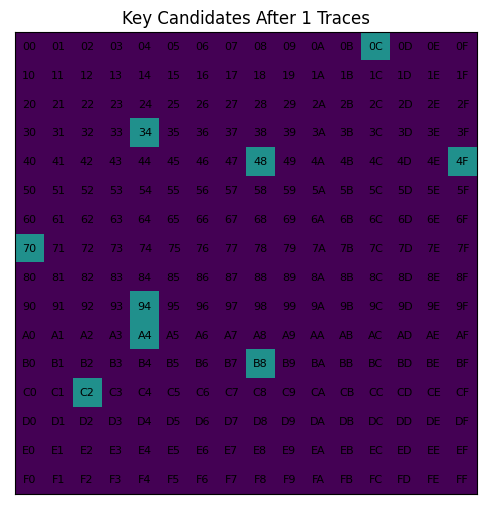

In [152]:
video_path = generate_mp4(f'{project_folder}/BIT_key_recovery_HD.mp4', 30, 10, get_k_counters_HD)
Video(video_path, embed=True)

### 🎉 GREAT SUCCESS!
We've successfully reduced the number of traces to just 4, less than a third of the original attack!

---

###### Reviewing Our Attacks & Results

| Model Name | Traces | #Classifiers per S-Box |
| ---------- | ------ | ----------------- |
| Hamming Weight | 4 | 36 |
| Bit model | 15 | 8 |
| Bit + HW | 6 | 44 |
| Bit + HD | 4 | 8 |

In this case, the Improved Bit + Hamming Distance model stands out as the clear winner. It results in a minimal number of traces required for the attack and fewer models per S-Box, leading to:
- Reduced training time
- Improved memory efficiency

This makes it a more practical and effective approach for key recovery.

---

`Note:` *Different setups will likely yield varying results, but this applies only to the **included** traces and models.*